# Mini-hackathon with the Credit Assignment Project (Open scope)

## Installation

Clone the github branch `minihack`:
[https://github.com/colleenjg/OpenScope_CA_Analysis/tree/minihack]()

Follow the installation with `conda` detailed on the README:
```bash
conda env create -f osca.yml
conda activate osca
```

From the root of the repo do:
```bash
$python sess_util/sess_download_util.py --output ../datasets/osca/
```

Now let 's get started!

In [1]:
import numpy as np
from minihack.load_data import get_calcium_traces, get_mouse_df
import matplotlib.pyplot as plt

# 1) Explore the dataset

The mouse dataframe saved into `mouse_df.csv` gives a quick overview of the dataset. Each row corresponds to a recording session, and in most cases the same mouse is imagined for three sessions corresponding to three consecutive days. In the following, I display the data from `prod` runtype to get the most reliable sessions.

In [2]:
df = get_mouse_df()
df = df[df['runtype'] == "prod"]
df

,sessid,dandi_session_id,mouse_n,mouseid,sex,DOB,date,age_weeks,depth,plane,...,nrois_tracked,nrois_all,nrois_allen,nrois_allen_all,pass_fail,all_files,any_files,incl,stim_seed,notes
33,758519303,20180926T172917,1,408021,M,20180623,20180926,13.571429,175,soma,...,59,116,96,116,P,1,1,yes,30587,NaN
34,759189643,20180927T182632,1,408021,M,20180623,20180927,13.714286,175,soma,...,59,86,74,86,P,1,1,yes,5730,NaN
35,759660390,20181001T172833,1,408021,M,20180623,20181001,14.285714,175,soma,...,59,121,107,121,P,1,1,yes,36941,NaN
36,759666166,20181001T180256,2,411400,F,20180711,20181001,11.714286,20,dend,...,-1,1009,70,79,F,1,1,yes,11883,"dropped beh and eye tracking frames (5), stim ..."
37,759872185,20181002T173740,2,411400,F,20180711,20181002,11.857143,20,dend,...,-1,309,53,58,F,1,1,yes,8005,"pupil recording truncated, dropped beh and eye..."
38,760269100,20181003T180253,2,411400,F,20180711,20181003,12.000000,20,dend,...,-1,539,75,86,F,1,1,yes,34380,"dropped beh and eye tracking frames (7), stim ..."
39,761730740,20181009T175037,2,411400,F,20180711,20181009,12.857143,20,dend,...,162,657,57,65,P,1,1,yes,44023,NaN
40,762415169,20181011T174057,2,411400,F,20180711,20181011,13.142857,20,dend,...,162,662,25,31,P,1,1,yes,29259,NaN
41,763646681,20181015T173410,2,411400,F,20180711,20181015,13.714286,20,dend,...,162,602,33,44,P,1,1,yes,1118,NaN
42,761624763,20181009T152254,3,411424,F,20180711,20181009,12.857143,175,soma,...,55,96,87,96,P,1,1,yes,997,NaN


We can also select specifically the sessions where the soma of the L5 pyramidal cells is being recorded.
I find three mice in this case: 4, 7, and 12. Each of them has normally 3 recording sessions.

In [3]:
df[(df['plane'] == "soma") & (df['line']=="L5-Rbp4")]

,sessid,dandi_session_id,mouse_n,mouseid,sex,DOB,date,age_weeks,depth,plane,...,nrois_tracked,nrois_all,nrois_allen,nrois_allen_all,pass_fail,all_files,any_files,incl,stim_seed,notes
45,760260459,20181003T174857,4,411771,M,20180713,20181003,11.714286,375,soma,...,47,104,90,104,P,1,1,yes,33767,NaN
46,760659782,20181004T173816,4,411771,M,20180713,20181004,11.857143,375,soma,...,47,76,70,76,P,1,1,yes,32698,NaN
47,761269197,20181008T172946,4,411771,M,20180713,20181008,12.428571,375,soma,...,47,99,9,99,P,1,1,yes,17904,NaN
57,777496949,20181113T015148,7,418779,F,20180820,20181112,12.000000,375,soma,...,12,31,15,31,P,1,1,yes,32706,NaN
58,778374308,20181114T030141,7,418779,F,20180820,20181113,12.142857,375,soma,...,12,56,26,56,P,1,1,yes,8114,NaN
59,779152062,20181115T010609,7,418779,F,20180820,20181114,12.285714,375,soma,...,12,55,29,55,P,1,1,yes,11744,NaN
73,826659257,20190221T162838,12,433458,M,20181106,20190221,15.285714,375,soma,...,70,126,99,126,P,1,1,yes,35969,NaN
74,827300090,20190222T161948,12,433458,M,20181106,20190222,15.428571,375,soma,...,70,107,87,107,P,1,1,yes,10378,NaN
75,828475005,20190225T162214,12,433458,M,20181106,20190225,15.857143,375,soma,...,70,118,97,118,P,1,1,yes,10576,"z-drift (10 um), passed QC after revision"
76,829520904,20190227T162140,12,433458,M,20181106,20190227,16.142857,375,soma,...,-1,109,88,109,P,1,1,yes,42270,NaN


# 2) Extract the calcium traces as a tensor

We use a little custom function which extracts the calcium traces and the interesting data into a tensor:

In [4]:
sess, roi_indices, roi_time_line, roi_data, condition_ids, mean_orientations, unexpected1 = get_calcium_traces(sess_n=1, mouse_n=4)

print("session info:", (sess.mouse_n, sess.line, sess.plane, sess.sess_n))

for tensor in [roi_indices, roi_time_line, roi_data, condition_ids, mean_orientations, unexpected1]:
    print(f"{tensor.shape} {tensor.dtype} \t {np.unique(tensor)[:3]}")

Extracting calcium data...


OSError: Could not find the directory or NWB file for session 760260459 (runtype prod) in ../../datasets/osca subfolders.

For further analysis we want to extract data across 3 consecutive days

In [113]:
mouse_n=4
sess1, roi_indices, roi_time_line, roi_data1, condition_ids, mean_orientations, unexpected1 = \
    get_calcium_traces(sess_n=1, mouse_n=mouse_n, scale=False)
sess2, _, _, roi_data2, _, _, unexpected2 = get_calcium_traces(sess_n=2, mouse_n=mouse_n)
sess3, _, _, roi_data3, _, _, unexpected3 = get_calcium_traces(sess_n=3, mouse_n=mouse_n)

Gabors (stimulus from session 760260459)
Gabors (stimulus from session 760659782)
Gabors (stimulus from session 761269197)


In [114]:
roi_data1.std((0,1,2)).min(), roi_data1.std((0,1,2)).max()

(0.05794014196869911, 0.6749178068676359)

The calcium traces vary more for some cells that others,
We will normalize the calcium traces to make sure each ROI has a calcium trace which varies more or less in $[-1, 1]$.

In [115]:
# compute mean and std across days to z score the traces.
roi_datas = np.stack([roi_data1, roi_data2, roi_data3], 0)
roi_datas_mean = roi_datas.mean((0,1,2,3))
roi_datas_std = roi_datas.std((0,1,2,3))

def z_score(x):
    assert len(x.shape) == 4
    z = (x - roi_datas_mean) / np.maximum(roi_datas_std, 1e-4)
    return z

x1 = z_score(roi_data1)
x2 = z_score(roi_data2)
x3 = z_score(roi_data3)

for i, x in enumerate([x1, x2, x3]):
    s = x.std((0,1,2))
    print("std at day {}: min {:.2f}, median {:.2f}, max {:.2f}".format(i, s.min(), np.mean(s), s.max()))

std at day 0: min 0.58, median 1.08, max 1.55
std at day 1: min 0.38, median 0.91, max 1.56
std at day 2: min 0.42, median 0.90, max 1.47


In [116]:
unexpected1.shape

(1360,)

# 3) Plot the data

First we will plot the calcium where averaged over trials and neurons, on the first day:

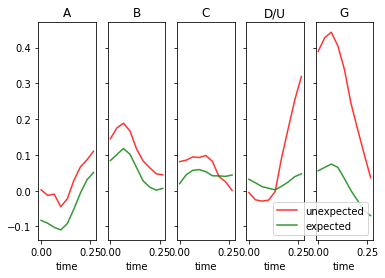

In [117]:
%matplotlib inline

cell_index = 0
x_mean_unexpected = x1[unexpected1].mean(0).mean(-1)
x_mean_expected = x1[np.logical_not(unexpected1)].mean(0).mean(-1)

_, ax_list = plt.subplots(1, 5, sharex="all", sharey="row")

for i in range(5):
    ax = ax_list[i]

    ts = np.arange(x1.shape[2]) * 1/30
    ax.plot(ts, x_mean_unexpected[i,:], color="red", alpha=0.8, label="unexpected")
    ax.plot(ts, x_mean_expected[i,:], color="green", alpha=0.8, label="expected")
    ax.set_xlabel("time")

ax_list[0].set_title("A")
ax_list[1].set_title("B")
ax_list[2].set_title("C")
ax_list[3].set_title("D/U")
ax_list[4].set_title("G")
ax_list[4].legend()

Let's plot the same thing but for specific cells:
We plot the trial averaged traces, for the cells which are most selective during the D/U and G period.

Text(0.5, 1.0, 'G')

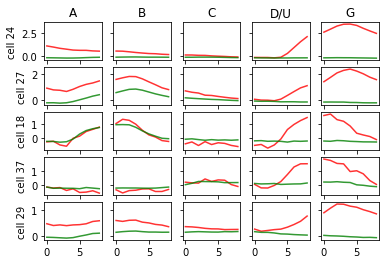

In [118]:
%matplotlib inline
mean_expected1 = x1[np.logical_not(unexpected1)].mean(0)
mean_unexpected1 = x1[unexpected1].mean(0)

mean_expected2 = x2[np.logical_not(unexpected2)].mean(0)
mean_unexpected2 = x2[unexpected2].mean(0)

mean_expected3 = x3[np.logical_not(unexpected3)].mean(0)
mean_unexpected3 = x3[unexpected3].mean(0)

selectivity_index = mean_expected1[3].mean(0) - mean_unexpected1[3].mean(0)
selectivity_index += mean_expected1[4].mean(0) - mean_unexpected1[4].mean(0)
selectivity_index = np.abs(selectivity_index)

cells = np.argsort(selectivity_index)[::-1][:5]
n_cells = len(cells)
_, ax_list = plt.subplots(n_cells, 5, sharex="all", sharey="row")

for j, cell_index in enumerate(cells):
    for i in range(5):
        ax = ax_list[j,i]
        ax.plot(mean_unexpected1[i,:,cell_index], color="red", alpha=0.8)
        ax.plot(mean_expected1[i,:,cell_index], color="green", alpha=0.8)
        if i ==0: ax.set_ylabel("cell {}".format(cell_index))

ax_list[0,0].set_title("A")
ax_list[0,1].set_title("B")
ax_list[0,2].set_title("C")
ax_list[0,3].set_title("D/U")
ax_list[0,4].set_title("G")


As a last result we want to plot the averaged selectivity to unexpected events across days:


Text(0.5, 0, 'days')

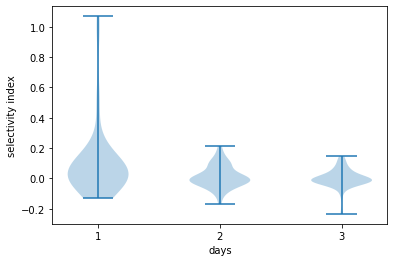

In [119]:
selectivity1 = x1[unexpected1].mean((0,1,2)) - x1[np.logical_not(unexpected1)].mean((0,1,2))
selectivity2 = x2[unexpected1].mean((0,1,2)) - x2[np.logical_not(unexpected1)].mean((0,1,2))
selectivity3 = x3[unexpected1].mean((0,1,2)) - x3[np.logical_not(unexpected1)].mean((0,1,2))

xs = [np.ones_like(selectivity1) * i for i in range(3)]
ys = [selectivity1, selectivity2, selectivity3]

_, ax = plt.subplots(1)
ax.violinplot([selectivity1, selectivity2, selectivity3])
ax.set_ylabel("selectivity index")
ax.set_xticks([1,2,3])
ax.set_xlabel("days")

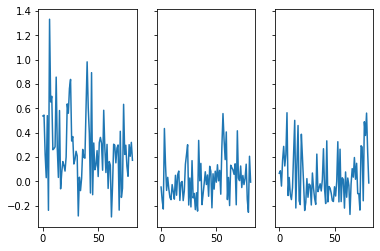

In [138]:
seg = 4
selectivity1 = x1[unexpected1][:,seg,:].mean((1,2)) - x1[np.logical_not(unexpected1)][:,seg,:].mean((0,1,2))
selectivity2 = x2[unexpected1][:,seg,:].mean((1,2)) - x2[np.logical_not(unexpected1)][:,seg,:].mean((0,1,2))
selectivity3 = x3[unexpected1][:,seg,:].mean((1,2)) - x3[np.logical_not(unexpected1)][:,seg,:].mean((0,1,2))


_, ax_list = plt.subplots(1,3, sharey="row")
for i, s in enumerate([selectivity1, selectivity2, selectivity3]):
    ax_list[i].plot(s)